# Build Model

In [1]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade
#!pip install Keras-Preprocessing

In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.16.1


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Settings

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Define file paths (you should use the same paths that you used for saving)
model_folder = 'model/base/'

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"



In [3]:
# Loading individual arrays
x_train = np.load('input/x_train.npy')
y_train = np.load('input/y_train.npy')
x_test = np.load('input/x_test.npy')
y_test = np.load('input/y_test.npy')

In [4]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [5]:
y_test[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]])

### Load w2v model

In [12]:
# Load the Word2Vec model
w2v_model = gensim.models.Word2Vec.load(model_folder + WORD2VEC_MODEL)

# Load the Tokenizer
with open(model_folder + TOKENIZER_MODEL, 'rb') as handle:
    tokenizer = pickle.load(handle)

2024-06-14 10:23:37,396 : INFO : loading Word2Vec object from model/base/model.w2v
2024-06-14 10:23:37,462 : INFO : loading wv recursively from model/base/model.w2v.wv.* with mmap=None
2024-06-14 10:23:37,463 : INFO : loading vectors from model/base/model.w2v.wv.vectors.npy with mmap=None
2024-06-14 10:23:37,495 : INFO : loading syn1neg from model/base/model.w2v.syn1neg.npy with mmap=None
2024-06-14 10:23:37,527 : INFO : setting ignored attribute cum_table to None
2024-06-14 10:23:38,560 : INFO : Word2Vec lifecycle event {'fname': 'model/base/model.w2v', 'datetime': '2024-06-14T10:23:38.560061', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}


In [16]:
words = w2v_model.wv.index_to_key

# Calculate vocabulary size
vocab_size = len(words) + 1
print("Total words", vocab_size)

Total words 290419


In [18]:
W2V_SIZE

300

### Embedding layer

In [20]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 100)


In [21]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Build Model

In [51]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1024, 300, 100)            │      29,041,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,041,900 (110.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 29,041,900 (110.79 MB)

### Compile model

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
early_stopping = EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5, mode='max')

# List of callbacks
callbacks = [reduce_lr, early_stopping]

### Train

array([[     0,      0,      0, ...,    712,    118,  24590],
       [     0,      0,      0, ...,    452,    378,  32447],
       [     0,      0,      0, ...,   2048,      4,   5487],
       ...,
       [     0,      0,      0, ...,    661,   4246, 290416],
       [     0,      0,      0, ...,     12,    477,    957],
       [     0,      0,      0, ...,      9,    502,    268]])

In [26]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 487s 432ms/step - accuracy: 0.7079 - loss: 0.5575 - val_accuracy: 0.7714 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 2/8


C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 489s 434ms/step - accuracy: 0.7432 - loss: 0.5132 - val_accuracy: 0.7761 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 496s 441ms/step - accuracy: 0.7486 - loss: 0.5061 - val_accuracy: 0.7781 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 515s 458ms/step - accuracy: 0.7502 - loss: 0.5023 - val_accuracy: 0.7794 - val_loss: 0.4629 - learning_rate: 0.0010
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 517s 459ms/step - accuracy: 0.7531 - loss: 0.4997 - val_accuracy: 0.7804 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 512s 455ms/step - accuracy: 0.7537 - loss: 0.4986 - val_accuracy: 0.7772 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 509s 452ms/step - accuracy: 0.7492 - loss: 0.5060 - val_accuracy: 0.7785 - val_loss: 0.4654 - learning_rate: 0.0010
Epoch 8/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 492s 437ms/step - accuracy:

### Evaluate

In [27]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 199ms/step - accuracy: 0.7807 - loss: 0.4609

ACCURACY: 0.780174970626831
LOSS: 0.4619930684566498
CPU times: total: 28.3 s
Wall time: 1min 2s


In [52]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


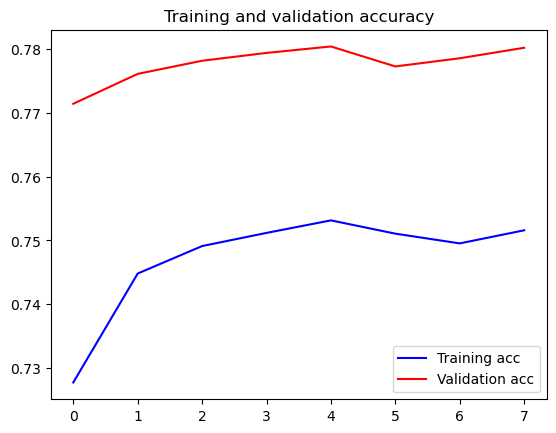

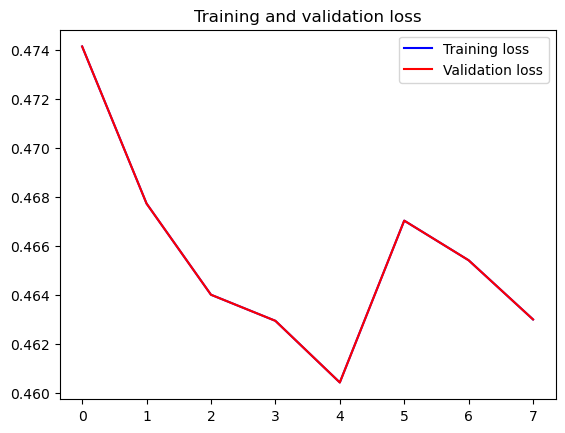

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['val_loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [30]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [31]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [32]:
predict("I love the music")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


{'label': 'POSITIVE',
 'score': 0.9510424733161926,
 'elapsed_time': 0.1296539306640625}

In [33]:
predict("I hate the rain")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


{'label': 'NEGATIVE',
 'score': 0.015717703849077225,
 'elapsed_time': 0.04474687576293945}

In [34]:
predict("i don't know what i'm doing")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


{'label': 'NEUTRAL',
 'score': 0.5259662866592407,
 'elapsed_time': 0.051894426345825195}

In [35]:
predict("I hate the hate speech")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


{'label': 'NEGATIVE',
 'score': 0.02503298781812191,
 'elapsed_time': 0.06110262870788574}

### Confusion Matrix

In [43]:
%%time
y_pred_1d = []
flat_list = y_test.flatten()
# Map the values to 'NEGATIVE' and 'POSITIVE'
y_test_1d = ['POSITIVE' if x == 1 else 'NEGATIVE' for x in flat_list]
#y_test_1d = y_test #list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
CPU times: total: 1min 42s
Wall time: 48.9 s


In [44]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [45]:
y_test_1d

['NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',

In [46]:
y_pred_1d

['NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',

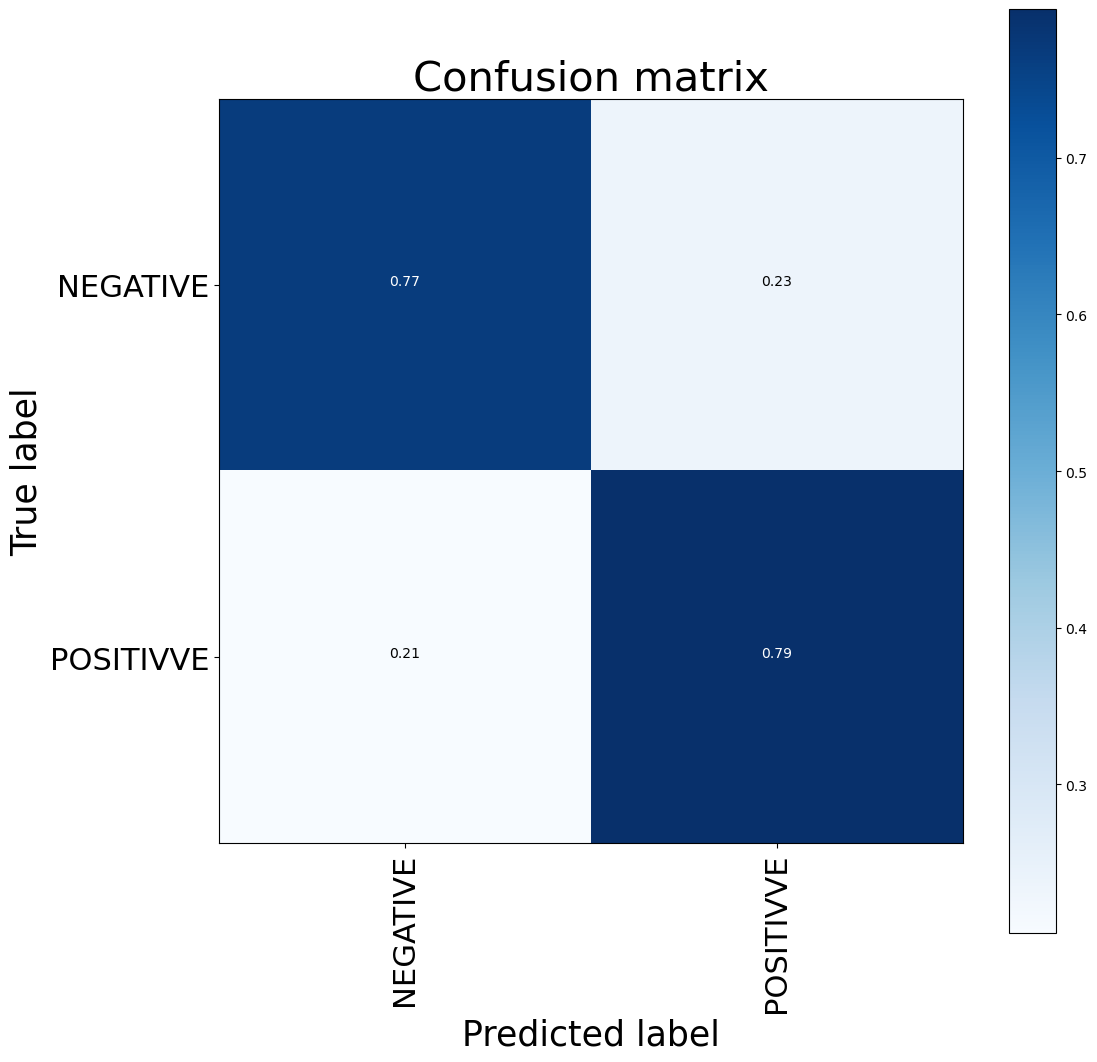

CPU times: total: 219 ms
Wall time: 700 ms


In [49]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=['NEGATIVE','POSITIVVE'], title="Confusion matrix")
plt.show()

### Classification Report

In [50]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.77      0.78    159494
    POSITIVE       0.77      0.79      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



### Accuracy Score

In [46]:
accuracy_score(y_test_1d, y_pred_1d)

0.783215625

### Save model

In [47]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2024-06-13 14:28:41,505 : WARNING : You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2024-06-13 14:28:41,624 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-06-13T14:28:41.624910', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-06-13 14:28:41,625 : INFO : storing np array 'vectors' to model.w2v.wv.vectors.npy
2024-06-13 14:28:41,695 : INFO : storing np array 'syn1neg' to model.w2v.syn1neg.npy
2024-06-13 14:28:41,766 : INFO : not storing attribute cum_table
2024-06-13 14:28:41,888 : INFO : saved model.w2v


### Load Model

In [9]:
from tensorflow.keras.models import load_model
from gensim.models import Word2Vec

KERAS_MODEL = "model/base/model.h5"
WORD2VEC_MODEL = "model/base/model.w2v"
TOKENIZER_MODEL = "model/base/tokenizer.pkl"
ENCODER_MODEL = "model/base/encoder.pkl"

# Load models and tokenizer
model = load_model(KERAS_MODEL)
w2v_model = Word2Vec.load(WORD2VEC_MODEL)
tokenizer = pickle.load(open(TOKENIZER_MODEL, "rb"))
encoder = pickle.load(open(ENCODER_MODEL, "rb"))

2024-06-21 22:29:18,996 : WARNING : Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2024-06-21 22:29:18,996 : INFO : loading Word2Vec object from model/base/model.w2v
2024-06-21 22:29:19,054 : INFO : loading wv recursively from model/base/model.w2v.wv.* with mmap=None
2024-06-21 22:29:19,054 : INFO : loading vectors from model/base/model.w2v.wv.vectors.npy with mmap=None
2024-06-21 22:29:19,120 : INFO : loading syn1neg from model/base/model.w2v.syn1neg.npy with mmap=None
2024-06-21 22:29:19,175 : INFO : setting ignored attribute cum_table to None
2024-06-21 22:29:20,254 : INFO : Word2Vec lifecycle event {'fname': 'model/base/model.w2v', 'datetime': '2024-06-21T22:29:20.254644', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
C:\Users\kwfen\AppData

In [10]:
# Read the CSV file
journal_path = 'data/csv/journal_data.csv'
j_df = pd.read_csv(journal_path, encoding=DATASET_ENCODING)
journals_test = j_df['journal'].values

# Tokenize and pad sequences
sequences = tokenizer.texts_to_sequences(journals_test)
max_len = max(len(seq) for seq in sequences)  # Determine appropriate max_len based on your data
X_test = pad_sequences(sequences, maxlen=max_len)

In [11]:
# Make predictions
predictions = model.predict(X_test)

# Get the predicted labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Extract positive class probabilities (for binary classification, it's the same as predictions)
positive_probabilities = predictions.flatten()

# Add predicted labels and positive probabilities to DataFrame
j_df['predicted_label'] = predicted_labels
j_df['positive_probability'] = positive_probabilities

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [12]:
output_path = 'data/csv/predicted_sentiments_lstm.csv'
j_df.to_csv(output_path, index=False)